# IMPORTS

In [4]:
## Work with arrays
import numpy as np
## Make figures
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import matplotlib.ticker as mticker
import seaborn as sns
## Draw maps
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.ticker import LatitudeLocator, LongitudeLocator
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
## Open netCDF-files
import netCDF4 as nc
## Manipulate data-frames
import pandas as pd
pd.options.mode.chained_assignment = None
## Manipulate dates
import datetime as dt
from dateutil.relativedelta import relativedelta

## SOME CONSTANTS

In [16]:
FILL_VALUE_FLOAT = np.nan
FILL_VALUE_INT = -999

VALID_QUALITIES = [0, 1, 2]

DT_0 = dt.datetime(1967,1,1,0,0)
DT_1 = dt.datetime(2020,1,1,0,0)

DATA_PATH_SROK8C = "/media/mrk/F6B4C17DB4C1413B/rihmi_wdc_data/srok8c_data/Srok8c/"
TSI_PATH = "../additional_data/ROB_TSI_composite_latest.txt"

# CATALOG

In [42]:
def converter(geoCoord: str):
    delimiter = geoCoord.find("°")
    if delimiter == -1:
        delimiter = geoCoord.find("о")
    if delimiter == -1:
        delimiter = geoCoord.find("o")
    return float(geoCoord[:delimiter]) + float(geoCoord[delimiter+1:delimiter+3])/60

In [43]:
stations = pd.read_csv(DATA_PATH_SROK8C+"../catalog.csv")

locs = np.empty((521,2))
for i in range(521):
    locs[i,0] = converter(stations["Широта"][i])
    locs[i,1] = converter(stations["Долгота"][i])  
    
stations['Широта'] = locs[:,0]
stations['Долгота'] = locs[:,1]
stations

,Индекс ВМО,Наименование станции,Широта,Долгота,Высота,Начало наблюдений,Примечание
0,20046,Им.Э.Т.Кренкеля,80.616667,58.050000,21,1966,NaN
1,20069,Остров Визе,79.500000,76.983333,12,1966,NaN
2,20087,Им.Г.А.Ушакова (Голомянный),79.550000,90.616667,7,1966,До 2015г. наз. Остров Голомянный
3,20107,Баренцбург,78.066667,14.250000,73,1966,NaN
4,20289,Русский,77.166667,96.433333,9,1966,Закрыта в 1999г.
...,...,...,...,...,...,...,...
516,37461,"Сулак, высокогорная",42.366667,46.250000,2927,1966,NaN
517,37470,Дербент,42.066667,48.300000,-19,1966,NaN
518,37471,Буйнакск,42.816667,47.116667,472,1966,NaN
519,37472,Махачкала,43.016667,47.483333,-20,1966,"С 1966г. по 11.1991г. – Махачкала,АЭ, ЮВ окраи..."


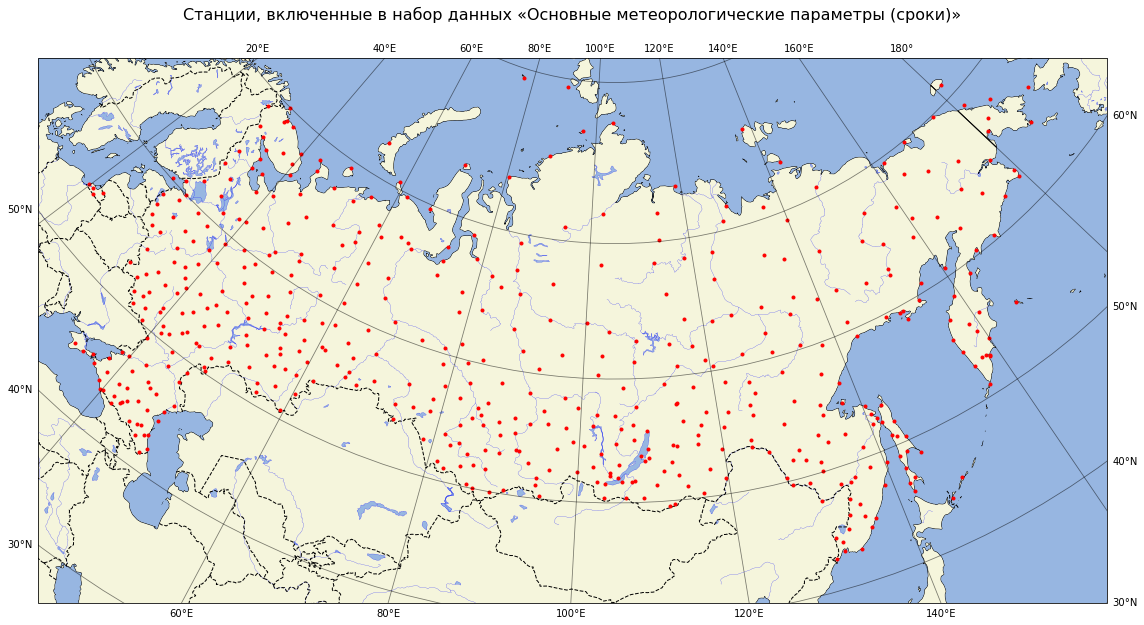

In [44]:
fig = plt.figure(figsize=(16,9), layout='tight')
lambert_crs = ccrs.LambertConformal(central_longitude=105, standard_parallels=(38.5, 38.5)) 
ax = fig.add_subplot(1,1,1,
                     projection=lambert_crs
                    )
ax.set_extent(
    [45, 155, 30, 75], 
    crs=ccrs.Geodetic()
)
# ax.coastlines(resolution='100m')
for loc in locs:
    plt.plot(
        loc[1], loc[0], 
        transform=ccrs.PlateCarree(),
        marker='.', color='red'
    )

resol = '50m'  # use data at this scale
bodr = cf.NaturalEarthFeature(category='cultural', 
    name='admin_0_boundary_lines_land', scale=resol, facecolor='none', alpha=0.7)
land = cf.NaturalEarthFeature('physical', 'land', \
    scale=resol, edgecolor='k', facecolor=cf.COLORS['land'])
ocean = cf.NaturalEarthFeature('physical', 'ocean', \
    scale=resol, edgecolor='none', facecolor=cf.COLORS['water'])
lakes = cf.NaturalEarthFeature('physical', 'lakes', \
    scale=resol, edgecolor='b', facecolor=cf.COLORS['water'])
rivers = cf.NaturalEarthFeature('physical', 'rivers_lake_centerlines', \
    scale=resol, edgecolor='b', facecolor='none')

ax.add_feature(land, facecolor='beige')
ax.add_feature(ocean, linewidth=0.2 )
ax.add_feature(lakes, linewidth=0.2)
ax.add_feature(rivers, linewidth=0.2)
ax.add_feature(bodr, linestyle='--', edgecolor='k', alpha=1)

gl = ax.gridlines(
    xlocs=np.arange(20,180+1,20), ylocs=np.arange(20,90+1,10),
    draw_labels=True, 
    dms=True, 
    x_inline=False,
    y_inline=False,
    alpha=0.5,
    color='k'
)
gl.rotate_labels = False

ax.set_title("Станции, включенные в набор данных «Основные метеорологические параметры (сроки)»\n", fontsize=16)
fig.savefig("rihmi_wdc_stations.png", dpi=250)

del locs

# METEOROLOGICAL CHARACTERISTICS

## TOTAL SOLAR IRRADIANCE

"Please, cite the following papers:"

S. Dewitte, J. Cornelis and M. Meftah. Centennial Total Solar Irradiance Variation. Remote Sens. 2022, 14, 1072. https://doi.org/10.3390/rs14051072 

S. Dewitte and S. Nevens, "The Total Solar Irradiance Climate Data Record", 2016 ApJ 830 25, http://iopscience.iop.org/article/10.3847/0004-637X/830/1/25

URL: https://www.sidc.be/observations/space-based-timelines/tsi

In [10]:
tsi = pd.read_csv(
    TSI_PATH, 
    delimiter=' ',
    skiprows=21,
    header=None,
    encoding='unicode_escape',
    names=['Floating point year', "TSI in W/m²", "Julian date"]
)
tsi

,Floating point year,TSI in W/m²,Julian date
0,1947.119781,1363.060059,2432231
1,1947.122519,1363.420044,2432232
2,1947.125257,1363.770020,2432233
3,1947.127995,1364.160034,2432234
4,1947.130732,1364.310059,2432235
...,...,...,...
27823,2023.921971,1363.760010,2460283
27824,2023.924709,1363.599976,2460284
27825,2023.927447,1363.599976,2460285
27826,2023.930185,1363.790039,2460286


In [13]:
def toDatetime(floatYear: float):
    year = int(floatYear)
    yearSize = 366 if (
        year%4==0 and year%100!=0
    ) or (year%400==0) else 365
    day = int((floatYear - int(floatYear)) * yearSize)
    return dt.datetime(year,1,1) + dt.timedelta(days=day-1)

In [15]:
len_ = (DT_1-DT_0).days

d = {
    "GMT date" : np.empty(len_),
    "TSI in W/m²" : np.full(len_, FILL_VALUE_FLOAT)
}

d["GMT date"] = np.array([DT_0 + relativedelta(days=i) for i in range(len_)])

date_tsi = np.array([toDatetime(fltYear) for fltYear in tsi['Floating point year'].to_numpy()])

for i, date in enumerate(d["GMT date"]):
    if i % 365 == 0:
        print(date)
    if sum(date_tsi==date) == 1:
        d["TSI in W/m²"][i] = float(tsi[date_tsi==date]["TSI in W/m²"])
    elif sum(date_tsi==date) > 1:
        d["TSI in W/m²"][i] = float(tsi[date_tsi==date]["TSI in W/m²"].mean())

tsi = pd.DataFrame(data=d)
tsi['TSI in W/m²'] = tsi['TSI in W/m²'].interpolate()

tsi.plot(x="GMT date")

1967-01-01 00:00:00
1968-01-01 00:00:00
1968-12-31 00:00:00
1969-12-31 00:00:00
1970-12-31 00:00:00
1971-12-31 00:00:00
1972-12-30 00:00:00
1973-12-30 00:00:00
1974-12-30 00:00:00
1975-12-30 00:00:00
1976-12-29 00:00:00
1977-12-29 00:00:00
1978-12-29 00:00:00
1979-12-29 00:00:00
1980-12-28 00:00:00
1981-12-28 00:00:00
1982-12-28 00:00:00
1983-12-28 00:00:00
1984-12-27 00:00:00
1985-12-27 00:00:00
1986-12-27 00:00:00
1987-12-27 00:00:00
1988-12-26 00:00:00
1989-12-26 00:00:00
1990-12-26 00:00:00
1991-12-26 00:00:00
1992-12-25 00:00:00
1993-12-25 00:00:00
1994-12-25 00:00:00
1995-12-25 00:00:00
1996-12-24 00:00:00
1997-12-24 00:00:00
1998-12-24 00:00:00
1999-12-24 00:00:00
2000-12-23 00:00:00
2001-12-23 00:00:00
2002-12-23 00:00:00
2003-12-23 00:00:00
2004-12-22 00:00:00
2005-12-22 00:00:00
2006-12-22 00:00:00
2007-12-22 00:00:00
2008-12-21 00:00:00
2009-12-21 00:00:00
2010-12-21 00:00:00
2011-12-21 00:00:00
2012-12-20 00:00:00
2013-12-20 00:00:00
2014-12-20 00:00:00
2015-12-20 00:00:00


,GMT date,TSI in W/m²
0,1967-01-01,1363.089966
1,1967-01-02,1362.839966
2,1967-01-03,1363.150024
3,1967-01-04,1362.979980
4,1967-01-05,1363.500000
...,...,...
19353,2019-12-27,1362.920044
19354,2019-12-28,1362.910034
19355,2019-12-29,1362.915039
19356,2019-12-30,1362.920044


## FORCING AND VALIDATION DATA FRAMES

In [183]:
def forcingAndValidDF(index: int):
    
    stationID = stations['Индекс ВМО'][index]
    lat = stations['Широта'][index]
    z = stations['Высота'][index]
    
    forcing = {
        "GMT datetime" : list(),
        "Downward short-wave radiation (W/m^2)" : list(),
        "Downward long-wave radiation (W/m^2)" : list(),
        "Wind speed (m/s)" : list(),
        "Precipitation rate (mm/s)" : list(),
        "Dry-bulb thermometer air temperature (°C)" : list(),
        "Specific air humidity (kg/kg)" : list(),
        "Air pressure at station level (Pa)" : list()
    }
    
    validation = {
        "GMT datetime" : list(),
        "Soil surface temperature (°C)" : list()
    }

    precip_tot = list()
    
    local_time = list()
    cloudiness = list()
    
    rel_hum_list = list()
    
    with open(
        DATA_PATH_SROK8C
        + f"{stationID}.dat"
    ) as f:
        for line in f:
            
            datetime_ = dt.datetime(
                int(line[6:10]), 
                int(line[11:13]), 
                int(line[14:16]),
                int(line[17:19])
            )
            
            if datetime_ < DT_0:
                continue
            
            if datetime_ >= DT_1:
                break
            
            forcing["GMT datetime"] += [datetime_]
            
            local_time += [int(line[37:39])]
            
            code = line[53:55]
            quality = int(line[56:57])
            cloudiness += [cldnssInPoints(code, quality)]
            
            # code = line[88:92]
            # quality = int(line[93:94])
            # method = line[95:96]
            # forcing["Cloud ceiling (m)"] += [cldClng(code, quality, method)]
            
            code = line[118:120]
            quality = int(line[121:122])
            idGT = line[123:124]
            forcing["Wind speed (m/s)"] += [windSpd(code, quality, idGT)]
            
            code = line[132:138]
            quality = int(line[139:140])
            precip_tot += [precip(code, quality)]
            
            code = line[181:186]
            quality = int(line[187:188])
            air_temp = temp(code, quality)
            forcing["Dry-bulb thermometer air temperature (°C)"] += [
                air_temp
            ]
            
            code = line[231:236]
            quality = int(line[237:238])
            prec = line[239:240]
            wat_partial_press = prs(code, quality, prec) # in Pascals
            
            code = line[241:244]
            quality = int(line[245:246])
            # forcing["Relative air humidity (%)"] += [rh(code, quality)]
            rel_hum = rh(code, quality)
            rel_hum_list += [rel_hum]
            
            code = line[267:273]
            quality = int(line[274:275])
            prec = "1"
            air_press = prs(code, quality, prec) # in Pascals
            forcing["Air pressure at station level (Pa)"] += [air_press]
            
            forcing["Specific air humidity (kg/kg)"] += [
                q_air(wat_partial_press, rel_hum, air_press, air_temp)
            ]
            
            validation["GMT datetime"] += [datetime_]
            
            code = line[141:146]
            quality = int(line[147:148])
            validation["Soil surface temperature (°C)"] += [temp(code, quality)]
    
    forcing['Precipitation rate (mm/s)'] = list(
        precipRate(precip_tot) / (3 * 3600)
    )
    
    # Radiation
    # cloudiness = pd.DataFrame(data=cloudiness).interpolate(limit=4, method='nearest').to_numpy()[:,0]
    local_time = np.array(local_time)
    
    forcing["Downward short-wave radiation (W/m^2)"] = rsds(
        cloudiness=cloudiness,
        gmt_date=forcing['GMT datetime'],
        local_time=local_time,
        tsi=tsi[["TSI in W/m²"]].to_numpy()[:,0],
        lat=lat,
        p=np.array(forcing["Air pressure at station level (Pa)"])/100
    )   
    
    forcing["Downward long-wave radiation (W/m^2)"] = rlds(
        air_temp=np.array(forcing["Dry-bulb thermometer air temperature (°C)"])+273.16,
        rel_hum=np.array(rel_hum_list),
        air_prs=np.array(forcing["Air pressure at station level (Pa)"])/100,
        cloudiness=cloudiness,
        z=z
    )
    
    forcing_df = pd.DataFrame(data=forcing)
    validation_df = pd.DataFrame(data=validation)
    
    # Delete outliers
    IQRFilter(forcing_df[forcing_df.columns[1:]])
    IQRFilter(validation_df[validation_df.columns[1:]])
    
    # Small gap filling
    forcing_df[forcing_df.columns[1:]] = forcing_df[forcing_df.columns[1:]].interpolate(limit=4, method='nearest')
    validation_df[validation_df.columns[1:]] = validation_df[validation_df.columns[1:]].interpolate(limit=4, method='nearest')
    
    return forcing_df, validation_df

def distanceBtwSunAndEarthInAU(day):
    # https://physics.stackexchange.com/questions/177949/earth-sun-distance-on-a-given-day-of-the-year
    return (1.0 - 0.01672 * np.cos((day-4)/365.256363*2*np.pi))

def solarDeclination(day):
    return np.arcsin(
        np.sin(-23.44 / 180 * np.pi) * np.cos(
            2*np.pi/365.24 * (day + 10) 
            + 2 * 0.0167 * np.sin(2*np.pi/365.24*(day - 2))
        )
    )

def rsds(cloudiness, gmt_date, local_time, tsi, lat, p):
    dayOfYear = np.array([
        1 + (date - dt.datetime(date.year,1,1)).days 
        for date in gmt_date
    ])
    r = distanceBtwSunAndEarthInAU(dayOfYear)
    delta = solarDeclination(dayOfYear)
    cz = (
        np.sin(lat/180*np.pi) * np.sin(delta)
        + np.cos(lat/180*np.pi) * np.cos(delta) 
        * np.cos(np.pi/12.0*local_time)
    )
    m = 2.0016 * p / (1013.25*(cz+np.sqrt(cz**2+0.003147)))
    t2 = 0.8
    
    res = np.full(len(gmt_date), FILL_VALUE_FLOAT)
    for i in range(len(res)):
        s0 = max(0.0, cz[i] * tsi[i//8] / r[i]**2 / (1+m[i]*(1-t2**2)/2*t2**2))
        s = s0 * (1 - cloudiness[i])
        d0 = max(0.0, 0.38 * cz[i] * (tsi[i//8] - s0))
        d = d0 * (1 - cloudiness[i]) + 0.34 * cloudiness[i] * (s0 + d0)
        res[i] = s + d
    return res

def rlds(air_temp, rel_hum, air_prs, cloudiness, z):
    DT_DZ = -0.0065 # K/m
    SIGMA = 5.6697e-8
    
    res = np.full(len(air_temp), FILL_VALUE_FLOAT)
    for i in range(len(res)):
        # e = rel_hum[i] 
        # epsilon = 0.532 + 0.808 * ()
        # res[i] = 0.76 * SIGMA * air_temp[i]**4 * (1 + 0.126 * cloudiness[i])**3.169
        t0 = air_temp[i] - DT_DZ * z
        e0 = rel_hum[i] / 100 * e_sat_fnc(t0) / 100
        # Marks, D., Dozier, J. A clear-sky longwave radiation model 
        # for remote alpine areas. Arch. Met. Geoph. Biokl. B. 27,
        # 159–187 (1979). https://doi.org/10.1007/BF02243741
        delta_a = 1.24 * (air_prs[i] / 1013.25) * (e0 / t0)**0.143
        
        B = 1
        if (air_temp[i] >= 273.16): #and ~np.isnan(cloudiness[i])):
            B = 1 + 0.17 * cloudiness[i]**2
        if (air_temp[i] < 273.16): # and ~np.isnan(cloudiness[i]) and ~np.isnan(rel_hum[i])):
            B = 1 + 0.4 * cloudiness[i] * (rel_hum[i] / 100)
        
        # print(B, delta_a, SIGMA * air_temp[i]**4, air_temp[i])
        # if i > 8:
        #     return None
        
        res[i] = B * delta_a * SIGMA * air_temp[i]**4
    
    return res

def q_air(
    wat_partial_press: float, 
    rel_hum: float, 
    air_press: float, 
    air_temp: float
) -> float:
    
    T_0 = 273.16
    
    res = FILL_VALUE_FLOAT
    
    if ~np.isnan(air_press):# != FILL_VALUE_FLOAT:
        if ~np.isnan(wat_partial_press):# != FILL_VALUE_FLOAT: 
            res = q_air_fnc(wat_partial_press, air_press)
        elif (
            ~np.isnan(rel_hum)# != FILL_VALUE_FLOAT
            and ~np.isnan(air_temp) # != FILL_VALUE_FLOAT
        ):
            wat_partial_press = (
                rel_hum * 0.01 * e_sat_fnc(air_temp + T_0)
            )
            res = q_air_fnc(wat_partial_press, air_press)
    return res

def e_sat_fnc(air_temp: float) -> float:
    E_0 = 611.21
    T_0 = 273.16
    if air_temp >= T_0:
        return E_0 * np.exp(
            17.502 * (air_temp - T_0) / (air_temp - 32.19)
        )
    else:
        return E_0 * np.exp(
            22.587 * (air_temp - T_0) / (air_temp + 0.7)
        )
        
def q_air_fnc(wat_partial_press: float, air_press: float) -> float:
    EPSILON = 287.0597 / 461.5250
    return EPSILON * wat_partial_press / (
                air_press - (1.0 - EPSILON) * wat_partial_press
            )

def precipRate(a):
    res = np.zeros_like(a)
    i0 = 0
    i1 = i0 + 1
    for i, aa in enumerate(a[1:]):
        if np.isnan(aa): #not (aa != FILL_VALUE_FLOAT):
            i1 += 1
        else:
            res[i0:i1] = aa / (i1 - i0)
            i0 = i
            i1 = i0 + 1
    return res

def rh(code: str, quality: int) -> float:
    res = FILL_VALUE_FLOAT
    if quality in VALID_QUALITIES:
        res = float(code)
    return res
            
def prs(code: str, quality: int, prec: str) -> float:
    res = FILL_VALUE_FLOAT
    if quality in VALID_QUALITIES:
        res = float(code)
        if prec == "1":
            res = np.round(res, -1)
        if prec == "2":
            res = np.round(res, -2)
        res *= 100
    return res

def temp(code: str, quality: int) -> float:
    res = FILL_VALUE_FLOAT
    if quality in VALID_QUALITIES:
        res = float(code)
    return res            
            
def precip(code: str, quality: int) -> float:
    res = FILL_VALUE_FLOAT
    if quality in VALID_QUALITIES:
        res = float(code)
    return res

def windSpd(code: str, quality: int, idGT: str) -> float:
    res = FILL_VALUE_FLOAT
    if quality in VALID_QUALITIES and idGT == "0":
        res = float(code)
    return res

def cldnssInPoints(code: str, quality: int) -> float:
    CLDNSS_11 = 0.05 #11
    CLDNSS_12 = 0.95 #12
    CLDNSS_13 = FILL_VALUE_FLOAT #13
    res = FILL_VALUE_FLOAT
    if quality in VALID_QUALITIES and code != "99":
        if code == "11":
            res = CLDNSS_11
        elif code == "12":
            res = CLDNSS_12
        elif code == "13":
            res = CLDNSS_13
        else:
            res = float(code) / 10.0
    return res

def cldClng(code: str, quality: int, method: str) -> float:
    res = FILL_VALUE_FLOAT
    if quality in VALID_QUALITIES and code != "    ":
        res = float(code)
    return res

def genCodes(start, end):
    res = list()
    if end > 99:
        return FILL_VALUE_FLOAT
    for i in range(start, end):
        if i < 10:
            res += [f"0{i}"]
        else:
            res += [f"{i}"]
    return res

def IQRFilter(df: pd.DataFrame):
    types = df.dtypes
    cols = df.columns
    for i, col in enumerate(cols):
        if str(types[i]) != 'float64':
            continue
        q25 = df[col][~np.isnan(df[col])].quantile(0.25)
        q75 = df[col][~np.isnan(df[col])].quantile(0.75)
        iqr = q75 - q25
        cutoff = 1.5 * iqr
        lower, upper = q25 - cutoff, q75 + cutoff
        df[col][df[col] < lower] = FILL_VALUE_FLOAT
        df[col][df[col] > upper] = FILL_VALUE_FLOAT

In [184]:
a, b = forcingAndValidDF(0)

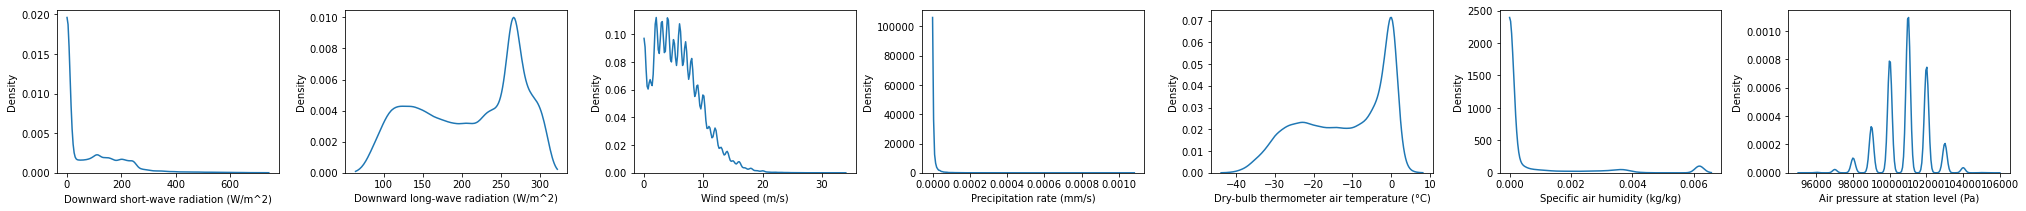

In [185]:
fig, ax = plt.subplots(1,len(a.columns[1:]), figsize=((3+2)*len(a.columns[1:]), 3))
for i, col in enumerate(a.columns[1:]):
    _ = sns.kdeplot(
        a[~np.isnan(a[col])], 
        x=col,
        ax=ax[i],
        clip=(a[~np.isnan(a[col])][col].min(),a[~np.isnan(a[col])][col].max())
    )
plt.subplots_adjust(wspace=0.3)

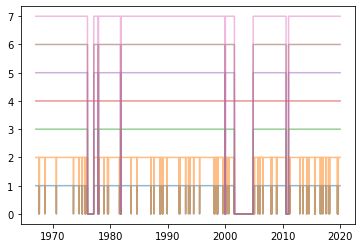

In [186]:
i = 0
for col in a.columns[1:]:
    i += 1
    plt.plot(a['GMT datetime'], ~np.isnan(a[col])[:] * i, alpha=0.5, label=col)
# plt.legend()

<AxesSubplot:>

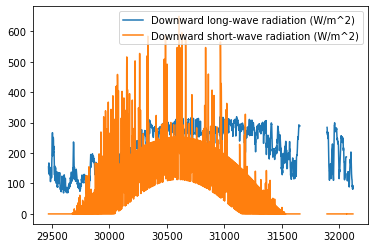

In [187]:
a[['Downward long-wave radiation (W/m^2)',"Downward short-wave radiation (W/m^2)"]][365*8*10:365*8*11].plot()
# a[[a.columns[-3]]][:365*8].plot()